In [79]:
import pandas as pd
import mne
import os
import numpy as np
from mne.time_frequency import tfr_morlet
import ast

In [80]:
# only importing subjects who we enforced fixation through out all blocks for
subs=['243','249','254','257','248','264','258'] #'255','246','261',,'227'

In [51]:
ROOT_preproc='/data/backed_up/shared/AlphaStudy_data/placeholders/preproc_EEG_matchingBrad/'
list_subs=subs#os.listdir(ROOT_preproc)
print(len(list_subs))
#list_subs.remove('206') # this sub is causing problems for the subject averaged neutral cues
#list_subs.remove('239')
print(len(list_subs))
preproc_cue_eps={}
preproc_probe_eps={}
for s in list_subs:
    cue=mne.read_epochs(ROOT_preproc+s+'/'+'cue-epo.fif')
    probe=mne.read_epochs(ROOT_preproc+s+'/'+'probe events-epo.fif')
    preproc_cue_eps[s]=cue
    preproc_probe_eps[s]=probe

7
7
Reading /data/backed_up/shared/AlphaStudy_data/placeholders/preproc_EEG_matchingBrad/243/cue-epo.fif ...
    Found the data of interest:
        t =   -1300.78 ...    1000.00 ms
        0 CTF compensation matrices available
599 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 16 columns
0 projection items activated
Reading /data/backed_up/shared/AlphaStudy_data/placeholders/preproc_EEG_matchingBrad/243/probe events-epo.fif ...
    Found the data of interest:
        t =       0.00 ...    5400.39 ms
        0 CTF compensation matrices available
595 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 16 columns
0 projection items activated
Reading /data/backed_up/shared/AlphaStudy_data/placeholders/preproc_EEG_matchingBrad/249/cue-epo.fif ...
    Found the data of interest:
        t =   -1300.78 ...    1000.00 ms
        0 CTF compensation matrices available
587 matching events found
Applying baseline correction (m

In [52]:
preproc_cue_eps['258'].metadata['block'].iloc[0]==1

True

In [53]:
this_trial.metadata['trial_type'].iloc[0]

'neut'

In [54]:
len(list_subs)

7

In [55]:
list_subs

['243', '249', '254', '257', '248', '264', '258']

In [56]:
right_stim=['1','3','5']
center_stim=['6','12']
left_stim=['7','9','11']

In [57]:
# We have to loop through each subject, each condition, 
# and find every trial that is *not* in the L, R, or center,
# and drop those tirals from 3 copies of the original epochs to get three
# copies that are only L, R, or Center trials

conditions=['tarShortCue_trig','disShortCue_trig',
           'tarLongCue_trig','disLongCue_trig']#,'neutShortCue_trig','neutLongCue_trig']
preprocCues_LeftH={}
preprocCues_RightH={}
preprocCues_Neutrals={}

for sub in preproc_cue_eps.keys():
    
    preprocCues_LeftH[sub]={}
    preprocCues_RightH[sub]={}
    preprocCues_Neutrals[sub]={}
    
    # load cue_epochs for this sub
    cue_eps=preproc_cue_eps[sub]
    
    # loop thru conditions
    for cond in conditions:
        epsForThisCond=cue_eps[cond]
                    
        # set up empty lists to be populated with trials that are NOT L/R/center
        not_right_end=[]
        not_right_begin=[]
        not_left_end=[]
        not_left_begin=[]
        # will populate w bools where True== drop this trial

        # loop thru each trial, and check out the metadata
        for trial_n in range(len(epsForThisCond)):
            this_trial=epsForThisCond[trial_n]

            assert this_trial.metadata['trial_type'].iloc[0] in cond            
            # grab out the behav data of this trial
            this_trial_BeginOrEnd=this_trial.metadata['block'].iloc[0]
            if this_trial_BeginOrEnd <6:
                trial_timing='FirstFive'
            elif this_trial_BeginOrEnd >=6:
                trial_timing='LastFive'
            this_trial_StimLoc=this_trial.metadata['tar,dis stim_loc'].iloc[0]
            this_trial_StimLoc=ast.literal_eval(this_trial_StimLoc) # turn it into a literal tuple

            # identify the condition of interest and pull out that stim loc
            if 'tar' in cond:
                thisClockPos=this_trial_StimLoc[0] 
                # if its the target that was the color singleton, we care about which
                                        # hemisphere that was in
            elif 'dis' in cond:
                thisClockPos=this_trial_StimLoc[1]

            # if the the clock pos is on the right side of the screen, 
                # then we want to document as not-not right, not left, and not center
            if thisClockPos in right_stim:
                if trial_timing=='FirstFive':
                    not_right_begin.append(False)
                    not_left_begin.append(True)
                    not_right_end.append(True)
                    not_left_end.append(True)
                elif trial_timing=='LastFive':
                    not_right_begin.append(True)
                    not_left_begin.append(True)
                    not_right_end.append(False)
                    not_left_end.append(True)
            elif thisClockPos in left_stim:
                if trial_timing=='FirstFive':
                    not_right_begin.append(True)
                    not_left_begin.append(False)
                    not_right_end.append(True)
                    not_left_end.append(True)
                elif trial_timing=='LastFive':
                    not_right_begin.append(True)
                    not_left_begin.append(True)
                    not_right_end.append(True)
                    not_left_end.append(False)
            else:
                not_right_end.append(True)
                not_left_end.append(True)
                not_right_begin.append(True)
                not_left_begin.append(True)

        print(len(not_right_end),len(not_left_end),len(not_left_begin),len(not_right_begin),len(epsForThisCond))
        assert len(not_right_end) == len(not_left_end)==len(not_right_begin)==len(not_left_begin) == len(epsForThisCond)

        # make three copies of the original epochs for this condition
        all_Rights_firstFive=epsForThisCond.copy()
        all_Lefts_firstFive=epsForThisCond.copy()
        all_Rights_lastFive=epsForThisCond.copy()
        all_Lefts_lastFive=epsForThisCond.copy()

        # then drop all of the epochs that are "True" in not being on the side of the screen we want
        all_Rights_firstFive.drop(indices=np.asarray(not_right_begin),reason='Dropping all left and centers')
        all_Lefts_firstFive.drop(indices=np.asarray(not_left_begin),reason='Dropping all right and centers')
        all_Rights_lastFive.drop(indices=np.asarray(not_right_end),reason='Dropping all left and centers')
        all_Lefts_lastFive.drop(indices=np.asarray(not_left_end),reason='Dropping all right and centers')



        # now put it into a dict
        preprocCues_LeftH[sub][cond]={}
        preprocCues_LeftH[sub][cond]['FirstFive']=all_Lefts_firstFive
        preprocCues_LeftH[sub][cond]['LastFive']=all_Lefts_lastFive
        preprocCues_RightH[sub][cond]={}
        preprocCues_RightH[sub][cond]['FirstFive']=all_Rights_firstFive
        preprocCues_RightH[sub][cond]['LastFive']=all_Rights_lastFive
        
        
        
            

100 100 100 100 100
Dropped 84 epochs
Dropped 82 epochs
Dropped 84 epochs
Dropped 76 epochs
100 100 100 100 100
Dropped 85 epochs
Dropped 80 epochs
Dropped 80 epochs
Dropped 81 epochs
100 100 100 100 100
Dropped 81 epochs
Dropped 79 epochs
Dropped 83 epochs
Dropped 80 epochs
99 99 99 99 99
Dropped 87 epochs
Dropped 78 epochs
Dropped 80 epochs
Dropped 81 epochs
99 99 99 99 99
Dropped 86 epochs
Dropped 78 epochs
Dropped 79 epochs
Dropped 83 epochs
96 96 96 96 96
Dropped 80 epochs
Dropped 78 epochs
Dropped 76 epochs
Dropped 76 epochs
96 96 96 96 96
Dropped 75 epochs
Dropped 80 epochs
Dropped 77 epochs
Dropped 77 epochs
99 99 99 99 99
Dropped 83 epochs
Dropped 79 epochs
Dropped 77 epochs
Dropped 85 epochs
99 99 99 99 99
Dropped 81 epochs
Dropped 83 epochs
Dropped 79 epochs
Dropped 84 epochs
92 92 92 92 92
Dropped 74 epochs
Dropped 75 epochs
Dropped 78 epochs
Dropped 74 epochs
98 98 98 98 98
Dropped 84 epochs
Dropped 78 epochs
Dropped 79 epochs
Dropped 75 epochs
97 97 97 97 97
Dropped 74 ep

In [58]:
preprocCues_LeftH['243']['tarShortCue_trig']['FirstFive'].metadata

,index,tar_color,dis_color,SOA,block,trialNum,trial_type,corrResp,subResp,trialCorr?,RT,"tar,dis stim_loc",ITI,"Tar,Dis,Other",trial_trigs,triggers
68,71,red,pink,short,1,11,tar,q,None,NaN,NaN,"('7', '1')",3.4,"('red_diamond', 'green_circle', 'green_circle')","(105, 117, 131)","({'dis_short_cue_trig': 101, 'dis_long_cue_tri..."
123,82,red,pink,short,1,22,tar,p,None,NaN,NaN,"('11', '9')",4.6,"('red_diamond', 'green_circle', 'green_circle')","(105, 117, 131)","({'dis_short_cue_trig': 101, 'dis_long_cue_tri..."
233,104,red,pink,short,1,44,tar,q,q,1.0,1.565622,"('9', '11')",3.8,"('red_diamond', 'green_circle', 'green_circle')","(105, 117, 131)","({'dis_short_cue_trig': 101, 'dis_long_cue_tri..."
341,5,red,pink,short,2,5,tar,p,p,1.0,1.598374,"('9', '6')",4.0,"('red_circle', 'green_diamond', 'green_diamond')","(105, 117, 131)","({'dis_short_cue_trig': 101, 'dis_long_cue_tri..."
521,41,red,pink,short,2,41,tar,q,q,1.0,1.236296,"('11', '12')",3.8,"('red_diamond', 'green_circle', 'green_circle')","(105, 117, 131)","({'dis_short_cue_trig': 101, 'dis_long_cue_tri..."
576,52,red,pink,short,2,52,tar,p,p,1.0,0.928788,"('11', '1')",3.4,"('red_diamond', 'green_circle', 'green_circle')","(105, 117, 131)","({'dis_short_cue_trig': 101, 'dis_long_cue_tri..."
678,132,red,pink,short,3,12,tar,p,p,1.0,0.849612,"('9', '12')",3.7,"('red_diamond', 'green_circle', 'green_circle')","(105, 117, 131)","({'dis_short_cue_trig': 101, 'dis_long_cue_tri..."
743,145,red,pink,short,3,25,tar,q,q,1.0,1.032937,"('11', '12')",4.5,"('red_diamond', 'green_circle', 'green_circle')","(105, 117, 131)","({'dis_short_cue_trig': 101, 'dis_long_cue_tri..."
798,156,red,pink,short,3,36,tar,q,q,1.0,0.793891,"('7', '11')",3.8,"('red_circle', 'green_diamond', 'green_diamond')","(105, 117, 131)","({'dis_short_cue_trig': 101, 'dis_long_cue_tri..."
843,165,red,pink,short,3,45,tar,p,p,1.0,1.414156,"('7', '3')",3.9,"('red_diamond', 'green_circle', 'green_circle')","(105, 117, 131)","({'dis_short_cue_trig': 101, 'dis_long_cue_tri..."


In [59]:
preproc_cue_eps['243']

<EpochsFIF  |   599 events (all good), -1.30078 - 1 sec, baseline [-1.30078, -0.3], ~350.4 MB, data loaded, with metadata,
 'disLongCue_trig': 99
 'disShortCue_trig': 100
 'neutLongCue_trig': 100
 'neutShortCue_trig': 100
 'tarLongCue_trig': 100
 'tarShortCue_trig': 100>

In [60]:
ex_neut=preproc_cue_eps['224']['neutLongCue_trig']
exNeut_firstBlocks=ex_neut[ex_neut.metadata['block'] < 6]
exNeut_firstBlocks.metadata

KeyError: '224'

In [62]:
freqs=np.arange(.5,38.,2.)
n_cycles = freqs / 2.
leftPost_elecs=['CP5','CP3','P7','P5','P3','PO3','PO7']
rightPost_elecs=['CP4','CP6','P4','P6','P8','PO4','PO8']
all_conds=['tarShortCue_trig','disShortCue_trig',
           'tarLongCue_trig','disLongCue_trig']
all_subs_Lefts={}
all_subs_Rights={}
all_subs_Neutrals={}

for SubDict in [preprocCues_LeftH, preprocCues_RightH]:
    
    for cond in all_conds:
        
        if SubDict == preprocCues_LeftH:
            all_subs_Lefts[cond]={}
        else:
            all_subs_Rights[cond]={}
        for block_order in ['FirstFive','LastFive']:
            # loading an example subject to steal the python object's structure
            # and overwrite the subject data with a group average
            skeleton_obj=mne.time_frequency.tfr_morlet(SubDict['243'][cond][block_order],freqs=freqs,n_cycles=n_cycles,
                                                       average=True,use_fft=True,return_itc=False, decim=2, n_jobs=1)
            thisCond_blockOrder_allSubsDat=[]
            for s in list_subs:
                #print('\n\n\n')
                thisSub=SubDict[s][cond][block_order]
                print('extracting sub {0}, cond {1},block type {2}'.format(s,cond,block_order))
                subDat=mne.time_frequency.tfr_morlet(thisSub,freqs=freqs,n_cycles=n_cycles,average=True,
                                                         use_fft=True,return_itc=False, decim=2, n_jobs=1)
                thisCond_blockOrder_allSubsDat.append(subDat.data)

            # compiling all subjects' data for this condition, in this hemisphere
            all_subs_thisCond=np.stack(thisCond_blockOrder_allSubsDat)
            # and averaging across the "subject" dimension
            assert all_subs_thisCond.shape[0] == len(list_subs)
            all_subs_thisCond=all_subs_thisCond.mean(axis=0)
            # then feeding that into the skeleton MNE averageTFR object
            skeleton_obj.data=all_subs_thisCond

            skeleton_obj.apply_baseline(mode='zscore', baseline=(-1.300, -0.5))
            
            if SubDict==preprocCues_LeftH:
                #print(all_subs_Lefts[cond])
                all_subs_Lefts[cond][block_order]=skeleton_obj
                print('Finished with left hemis for this cond')
            elif SubDict==preprocCues_RightH:
                all_subs_Rights[cond][block_order]=skeleton_obj
                print('Finished with right hemis for this cond') 

/home/dcellier/condaenvs/p3env/lib/python3.7/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


extracting sub 243, cond tarShortCue_trig,block type FirstFive
extracting sub 249, cond tarShortCue_trig,block type FirstFive
extracting sub 254, cond tarShortCue_trig,block type FirstFive
extracting sub 257, cond tarShortCue_trig,block type FirstFive
extracting sub 248, cond tarShortCue_trig,block type FirstFive
extracting sub 264, cond tarShortCue_trig,block type FirstFive
extracting sub 258, cond tarShortCue_trig,block type FirstFive
Applying baseline correction (mode: zscore)
Finished with left hemis for this cond
extracting sub 243, cond tarShortCue_trig,block type LastFive
extracting sub 249, cond tarShortCue_trig,block type LastFive
extracting sub 254, cond tarShortCue_trig,block type LastFive
extracting sub 257, cond tarShortCue_trig,block type LastFive
extracting sub 248, cond tarShortCue_trig,block type LastFive
extracting sub 264, cond tarShortCue_trig,block type LastFive
extracting sub 258, cond tarShortCue_trig,block type LastFive
Applying baseline correction (mode: zscore

Applying baseline correction (mode: zscore)
Finished with right hemis for this cond


In [63]:
all_subs_thisCond.shape

(64, 19, 590)

In [64]:
#subDat_firsts.data
#all_subs_thisCond_firsts
#skeleton_obj_lastBlocks=mne.time_frequency.tfr_morlet(skeleton_neut_lastBlocks,freqs=freqs,n_cycles=n_cycles,
                                              #   average=True,use_fft=True,return_itc=False, decim=2, n_jobs=1)

print(all_subs_Lefts[cond])
#thisCond_allSubsDat_lasts

{'FirstFive': <AverageTFR  |  time : [-1.300781, 1.000000], freq : [0.500000, 36.500000], nave : 21, channels : 64, ~5.7 MB>, 'LastFive': <AverageTFR  |  time : [-1.300781, 1.000000], freq : [0.500000, 36.500000], nave : 18, channels : 64, ~5.7 MB>}


In [66]:


neuts=['neutLongCue_trig','neutShortCue_trig']
for SubDict in [preproc_cue_eps]:
    
    for cond in neuts: 
        # loading an example subject to steal the python object's structure
        # and overwrite the subject data with a group average
        skeleton_neut=SubDict['243'][cond]
        skeleton_neut_firstBlocks=skeleton_neut[skeleton_neut.metadata['block'] < 6]
        skeleton_neut_lastBlocks=skeleton_neut[skeleton_neut.metadata['block'] >= 6]

        skeleton_obj_firstBlocks=mne.time_frequency.tfr_morlet(skeleton_neut_firstBlocks,freqs=freqs,n_cycles=n_cycles,
                                                   average=True,use_fft=True,return_itc=False, decim=2, n_jobs=1)
        skeleton_obj_lastBlocks=mne.time_frequency.tfr_morlet(skeleton_neut_lastBlocks,freqs=freqs,n_cycles=n_cycles,
                                                   average=True,use_fft=True,return_itc=False, decim=2, n_jobs=1)
        
        thisCond_allSubsDat_firsts=[]
        thisCond_allSubsDat_lasts=[]
        for s in list_subs:
            #print('\n\n\n')
            thisSub=SubDict[s][cond]
            thisSub_firsts=thisSub[thisSub.metadata['block']<6]
            thisSub_lasts=thisSub[thisSub.metadata['block']>=6]
            print('extracting sub {0}, cond {1}'.format(s,cond))
            subDat_firsts=mne.time_frequency.tfr_morlet(thisSub_firsts,freqs=freqs,n_cycles=n_cycles,average=True,
                                                     use_fft=True,return_itc=False, decim=2, n_jobs=1)
            subDat_lasts=mne.time_frequency.tfr_morlet(thisSub_lasts,freqs=freqs,n_cycles=n_cycles,average=True,
                                                     use_fft=True,return_itc=False, decim=2, n_jobs=1)
            thisCond_allSubsDat_firsts.append(subDat_firsts.data)
            thisCond_allSubsDat_lasts.append(subDat_lasts.data)

        # compiling all subjects' data for this condition, in this hemisphere
        all_subs_thisCond_firsts=np.stack(thisCond_allSubsDat_firsts)
        # and averaging across the "subject" dimension
        assert all_subs_thisCond_firsts.shape[0] == len(list_subs)
        all_subs_thisCond_firsts=all_subs_thisCond_firsts.mean(axis=0)
        # then feeding that into the skeleton MNE averageTFR object
        skeleton_obj_firstBlocks.data=all_subs_thisCond_firsts

        skeleton_obj_firstBlocks.apply_baseline(mode='zscore', baseline=(-1.300, -0.5))
        
        # compiling all subjects' data for this condition, in this hemisphere
        all_subs_thisCond_lasts=np.stack(thisCond_allSubsDat_lasts)
        # and averaging across the "subject" dimension
        assert all_subs_thisCond_lasts.shape[0] == len(list_subs)
        all_subs_thisCond_lasts=all_subs_thisCond_lasts.mean(axis=0)
        # then feeding that into the skeleton MNE averageTFR object
        skeleton_obj_lastBlocks.data=all_subs_thisCond_lasts

        skeleton_obj_lastBlocks.apply_baseline(mode='zscore', baseline=(-1.300, -0.5))


        all_subs_Neutrals[cond]={}
        all_subs_Neutrals[cond]['FirstFive']=skeleton_obj_firstBlocks
        all_subs_Neutrals[cond]['LastFive']=skeleton_obj_lastBlocks
        print('Finished with all subs epochs for this cond')

extracting sub 243, cond neutLongCue_trig
extracting sub 249, cond neutLongCue_trig
extracting sub 254, cond neutLongCue_trig
extracting sub 257, cond neutLongCue_trig
extracting sub 248, cond neutLongCue_trig
extracting sub 264, cond neutLongCue_trig
extracting sub 258, cond neutLongCue_trig
Applying baseline correction (mode: zscore)
Applying baseline correction (mode: zscore)
Finished with all subs epochs for this cond
extracting sub 243, cond neutShortCue_trig
extracting sub 249, cond neutShortCue_trig
extracting sub 254, cond neutShortCue_trig
extracting sub 257, cond neutShortCue_trig
extracting sub 248, cond neutShortCue_trig
extracting sub 264, cond neutShortCue_trig
extracting sub 258, cond neutShortCue_trig
Applying baseline correction (mode: zscore)
Applying baseline correction (mode: zscore)
Finished with all subs epochs for this cond


## Target Long SOA, target cue in right visual field, LAST FIVE blocks minus FIRST FIVE

In [67]:
#center.data
#latMinusCenter.data.shape



plotting RIGHT hemisphere last minus first blocks for tarLongCue_trig

No baseline correction applied


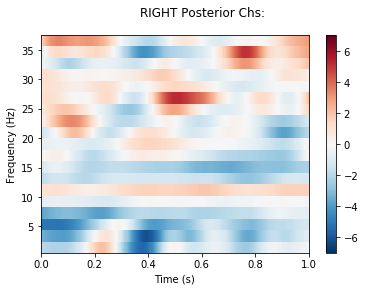

No baseline correction applied


/home/dcellier/condaenvs/p3env/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


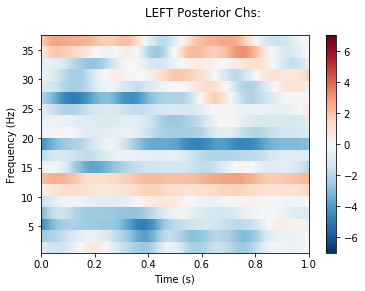

Plotting theta 0-200msec
No baseline correction applied


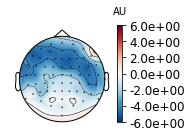

Plotting theta 200-400msec
No baseline correction applied


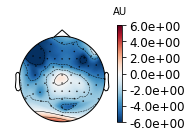

Plotting theta 400-800msec
No baseline correction applied


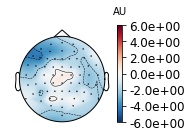

Plotting theta 800-1000msec
No baseline correction applied


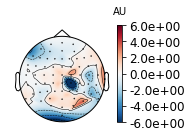

Plotting Alpha band
No baseline correction applied


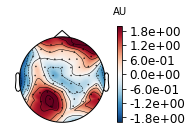

No baseline correction applied


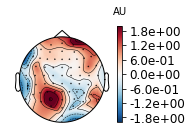

No baseline correction applied


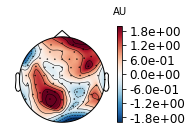

No baseline correction applied


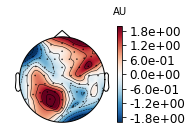

No baseline correction applied


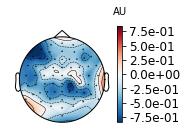

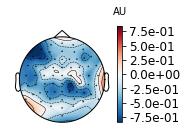

In [73]:
cond='tarLongCue_trig'
## Contrasting with centrally presented:
LastFive=all_subs_Rights[cond]['LastFive']
FirstFive=all_subs_Rights[cond]['FirstFive']
LastMinusFirst=LastFive-FirstFive
print('\n\nplotting RIGHT hemisphere last minus first blocks for %s\n' %cond)
LastMinusFirst.plot(vmin=-7,vmax=7,tmin=0,tmax=1,picks=rightPost_elecs,title='RIGHT Posterior Chs:').show()
LastMinusFirst.plot(vmin=-7,vmax=7,tmin=0,tmax=1,picks=leftPost_elecs,title='LEFT Posterior Chs:').show()

print('Plotting theta 0-200msec')
LastMinusFirst.plot_topomap(fmin=4,fmax=8,tmin=0,tmax=0.2,vmin=-6,vmax=6)
print('Plotting theta 200-400msec')
LastMinusFirst.plot_topomap(fmin=4,fmax=8,tmin=0.2,tmax=0.4,vmin=-6,vmax=6)
print('Plotting theta 400-800msec')
LastMinusFirst.plot_topomap(fmin=4,fmax=8,tmin=0.4,tmax=0.8,vmin=-6,vmax=6)
print('Plotting theta 800-1000msec')
LastMinusFirst.plot_topomap(fmin=4,fmax=8,tmin=0.8,tmax=1,vmin=-6,vmax=6)

print('Plotting Alpha band')
LastMinusFirst.plot_topomap(fmin=8,fmax=14,tmin=0,tmax=0.2,vmin=-2,vmax=2)

LastMinusFirst.plot_topomap(fmin=8,fmax=14,tmin=0.2,tmax=0.4,vmin=-2,vmax=2)
LastMinusFirst.plot_topomap(fmin=8,fmax=14,tmin=0.4,tmax=0.8,vmin=-2,vmax=2)
LastMinusFirst.plot_topomap(fmin=8,fmax=14,tmin=0.8,tmax=1,vmin=-2,vmax=2)
#,size=6,title='800-1000Ms')

mne.viz.plot_tfr_topomap(tfr=LastMinusFirst)

## Target Cue Long SOA, target cue in Left visual field, LAST FIVE BLOCKS minus FIRST FIVE



plotting LEFT hemisphere last minus first blocks for tarLongCue_trig

No baseline correction applied


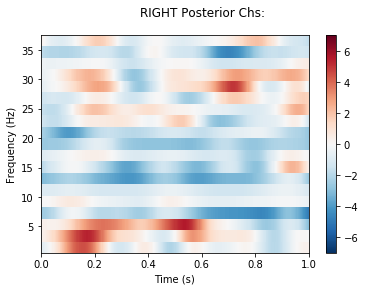

No baseline correction applied


/home/dcellier/condaenvs/p3env/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


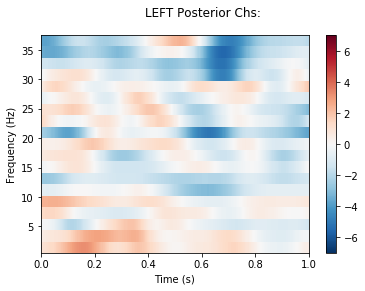

Plotting theta 0-200msec
No baseline correction applied


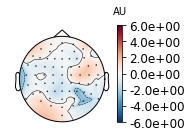

Plotting theta 200-400msec
No baseline correction applied


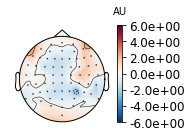

Plotting theta 400-800msec
No baseline correction applied


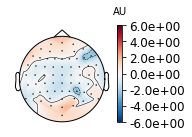

Plotting theta 800-1000msec
No baseline correction applied


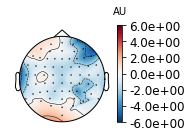

Plotting Alpha band
No baseline correction applied


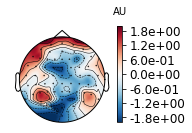

No baseline correction applied


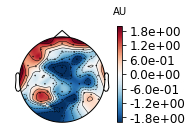

No baseline correction applied


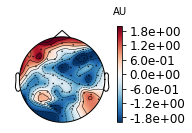

No baseline correction applied


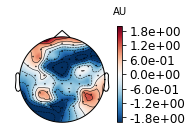

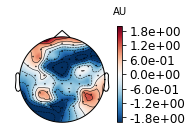

In [76]:
cond='tarLongCue_trig'
## Contrasting with centrally presented:
LastFive=all_subs_Lefts[cond]['LastFive']
FirstFive=all_subs_Lefts[cond]['FirstFive']
LastMinusFirst=LastFive-FirstFive
print('\n\nplotting LEFT hemisphere last minus first blocks for %s\n' %cond)
LastMinusFirst.plot(vmin=-7,vmax=7,tmin=0,tmax=1,picks=rightPost_elecs,title='RIGHT Posterior Chs:').show()
LastMinusFirst.plot(vmin=-7,vmax=7,tmin=0,tmax=1,picks=leftPost_elecs,title='LEFT Posterior Chs:').show()

print('Plotting theta 0-200msec')
LastMinusFirst.plot_topomap(fmin=4,fmax=8,tmin=0,tmax=0.2,vmin=-6,vmax=6)
print('Plotting theta 200-400msec')
LastMinusFirst.plot_topomap(fmin=4,fmax=8,tmin=0.2,tmax=0.4,vmin=-6,vmax=6)
print('Plotting theta 400-800msec')
LastMinusFirst.plot_topomap(fmin=4,fmax=8,tmin=0.4,tmax=0.8,vmin=-6,vmax=6)
print('Plotting theta 800-1000msec')
LastMinusFirst.plot_topomap(fmin=4,fmax=8,tmin=0.8,tmax=1,vmin=-6,vmax=6)

print('Plotting Alpha band')
LastMinusFirst.plot_topomap(fmin=8,fmax=14,tmin=0,tmax=0.2,vmin=-2,vmax=2)
LastMinusFirst.plot_topomap(fmin=8,fmax=14,tmin=0.2,tmax=0.4,vmin=-2,vmax=2)
LastMinusFirst.plot_topomap(fmin=8,fmax=14,tmin=0.4,tmax=0.8,vmin=-2,vmax=2)#,size=6)#,title='L400-800Ms')
LastMinusFirst.plot_topomap(fmin=8,fmax=14,tmin=0.8,tmax=1,vmin=-2,vmax=2)#,size=6)#,title='L800-1000Ms')

## Distractor Long SOA, where distractor is on the right, LAST FIVE BLOCKS



plotting RIGHT hemisphere last minus first blocks for disLongCue_trig

No baseline correction applied


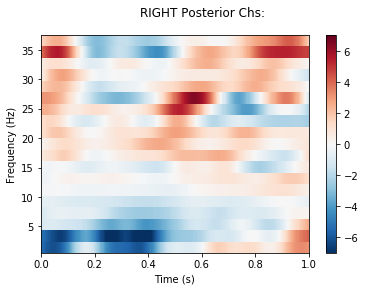

No baseline correction applied


/home/dcellier/condaenvs/p3env/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


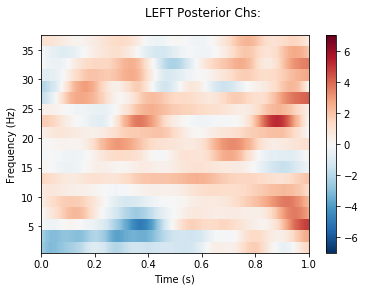

Plotting Alpha band
No baseline correction applied


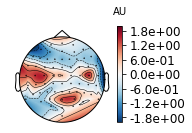

No baseline correction applied


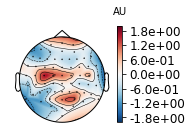

No baseline correction applied


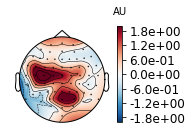

No baseline correction applied


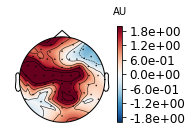

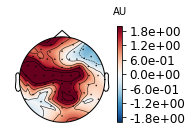

In [77]:
cond='disLongCue_trig'
## Contrasting with centrally presented:
LastFive=all_subs_Rights[cond]['LastFive']
FirstFive=all_subs_Rights[cond]['FirstFive']
LastMinusFirst=LastFive-FirstFive
print('\n\nplotting RIGHT hemisphere last minus first blocks for %s\n' %cond)
LastMinusFirst.plot(vmin=-7,vmax=7,tmin=0,tmax=1,picks=rightPost_elecs,title='RIGHT Posterior Chs:').show()
LastMinusFirst.plot(vmin=-7,vmax=7,tmin=0,tmax=1,picks=leftPost_elecs,title='LEFT Posterior Chs:').show()

print('Plotting Alpha band')
LastMinusFirst.plot_topomap(fmin=8,fmax=14,tmin=0,tmax=0.2,vmin=-2,vmax=2)
LastMinusFirst.plot_topomap(fmin=8,fmax=14,tmin=0.2,tmax=0.4,vmin=-2,vmax=2)
LastMinusFirst.plot_topomap(fmin=8,fmax=14,tmin=0.4,tmax=0.8,vmin=-2,vmax=2)
LastMinusFirst.plot_topomap(fmin=8,fmax=14,tmin=0.8,tmax=1,vmin=-2,vmax=2)#,size=6,title='R800-1000Ms')

## Dis Long SOA, distractor on Left, last 5 blocks minus first 5



plotting LEFT hemisphere last minus first blocks for disLongCue_trig

No baseline correction applied


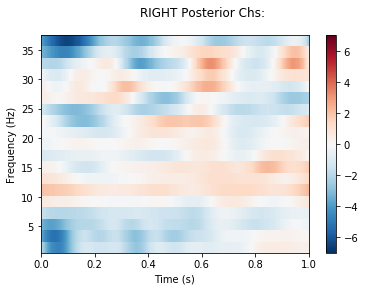

No baseline correction applied


/home/dcellier/condaenvs/p3env/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


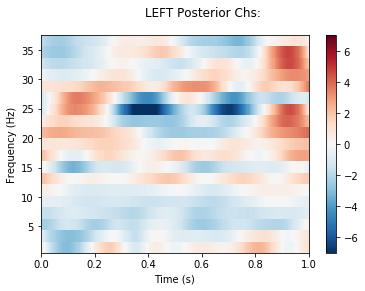

Plotting Alpha band
0-200 MS
No baseline correction applied


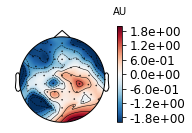

200-400 MS
No baseline correction applied


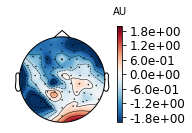

400-800 MS
No baseline correction applied


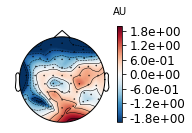

800-1000 MS
No baseline correction applied


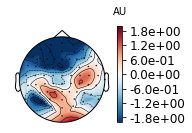

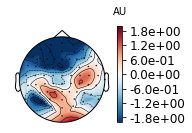

In [78]:
cond='disLongCue_trig'
## Contrasting with centrally presented:
LastFive=all_subs_Lefts[cond]['LastFive']
FirstFive=all_subs_Lefts[cond]['FirstFive']
LastMinusFirst=LastFive-FirstFive
print('\n\nplotting LEFT hemisphere last minus first blocks for %s\n' %cond)
LastMinusFirst.plot(vmin=-7,vmax=7,tmin=0,tmax=1,picks=rightPost_elecs,title='RIGHT Posterior Chs:').show()
LastMinusFirst.plot(vmin=-7,vmax=7,tmin=0,tmax=1,picks=leftPost_elecs,title='LEFT Posterior Chs:').show()

print('Plotting Alpha band')
print("0-200 MS")
LastMinusFirst.plot_topomap(fmin=8,fmax=14,tmin=0,tmax=0.2,vmin=-2,vmax=2)
print('200-400 MS')
LastMinusFirst.plot_topomap(fmin=8,fmax=14,tmin=0.2,tmax=0.4,vmin=-2,vmax=2)
print('400-800 MS')
LastMinusFirst.plot_topomap(fmin=8,fmax=14,tmin=0.4,tmax=0.8,vmin=-2,vmax=2)#,size=6,title='L400-800Ms')
print('800-1000 MS')
LastMinusFirst.plot_topomap(fmin=8,fmax=14,tmin=0.8,tmax=1,vmin=-2,vmax=2)#,size=6,title='L800-1000Ms')